In [1]:
import pandas as pd
import helper_fn as hf
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import mifs
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import os
from scipy.stats import kruskal
from tabulate import tabulate
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import logit
import pdb
from matplotlib.lines import Line2D
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
import scipy.stats as stats
import plotly.express as px
from scipy.stats import entropy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read Data

In [2]:
data_save_path = "/Users/raghavtandon/Documents/PhD/multi-modal/data"
figure_save_path = "/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/final_figures_v4"

In [3]:
X, X_unscaled, label_df = hf.readData()
# Get the different pairwise subject identified
dx_ctrl_ad, dx_ctrl_asym, dx_asym_ad = hf.filterClassPairs(label_df)
labels_train, labels_test = train_test_split(label_df, train_size=0.8, random_state=1)
dx_tr_ctrl_ad, dx_tr_ctrl_asym, dx_tr_asym_ad = hf.filterClassPairs(labels_train)
dx_te_ctrl_ad, dx_te_ctrl_asym, dx_te_asym_ad = hf.filterClassPairs(labels_test)

## Correlation and Scree Plots

(392, 75)


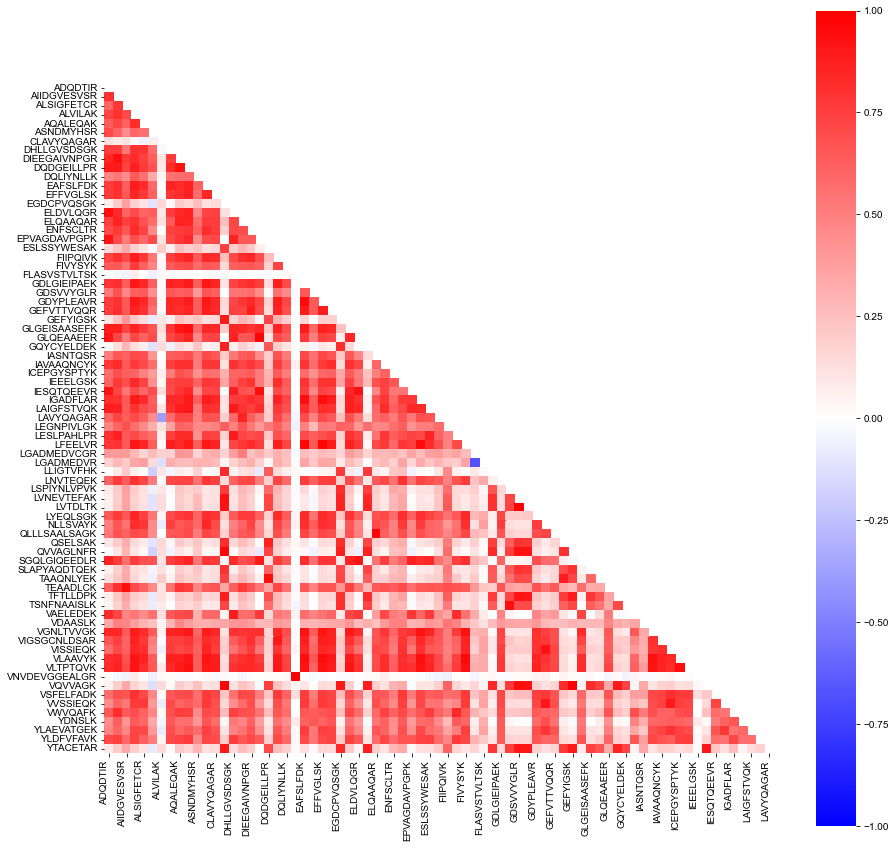

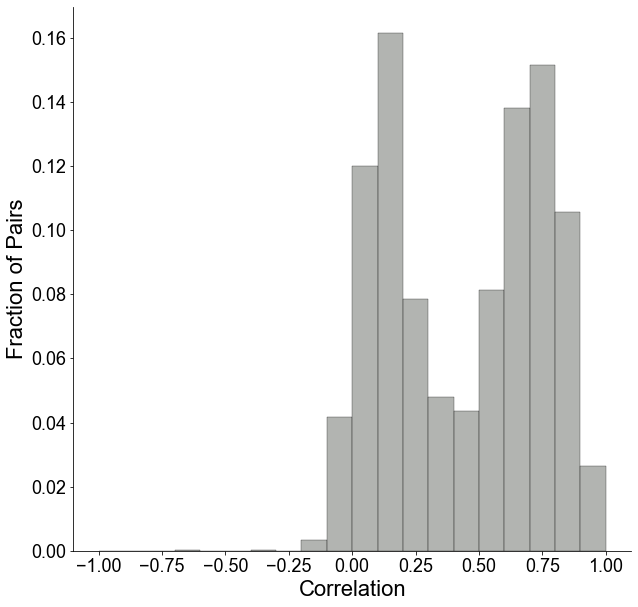

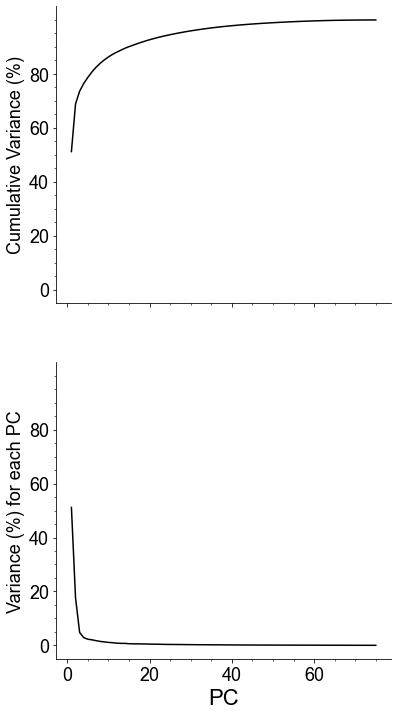

In [4]:
hf.correlation_distr(X, label_df["sbj"], X.columns.tolist(), "all")
hf.scree_plots(X, label_df["sbj"])

## Identify peptides (using RFE) and predict performance on held-out dataset

In [5]:
n=14
random_seed = 0
rfe_protein_ctrl_ad = hf.protein_selection(X, dx_tr_ctrl_ad, n, random_seed)
rfe_protein_ctrl_asym = hf.protein_selection(X, dx_tr_ctrl_asym, n, random_seed)
rfe_protein_asym_ad = hf.protein_selection(X, dx_tr_asym_ad, n, random_seed)

In [6]:
clf = LogisticRegression( C=1.0, random_state=random_seed, dual=False, max_iter=3000)
# clf = MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), batch_size=64, max_iter=2000, 
#                    random_state=0, tol=1e-6)
# clf = RandomForestClassifier(max_depth=None, random_state=0, 
#                                         max_features=None, n_jobs=-1,
#                                         ccp_alpha=0.01)

In [7]:
y_test_ca, y_pred_ca = hf.prediction_fn(X, dx_tr_ctrl_ad, dx_te_ctrl_ad, rfe_protein_ctrl_ad, 
										clf, random_seed)
print("Control vs AD", sm.accuracy_score(y_test_ca, y_pred_ca), len(rfe_protein_ctrl_ad))
y_test_cas, y_pred_cas = hf.prediction_fn(X, dx_tr_ctrl_asym, dx_te_ctrl_asym, rfe_protein_ctrl_asym,
										clf, random_seed)
print("Control vs AsymAD", sm.accuracy_score(y_test_cas, y_pred_cas), len(rfe_protein_ctrl_asym))
y_test_asad, y_pred_asad = hf.prediction_fn(X, dx_tr_asym_ad, dx_te_asym_ad, rfe_protein_asym_ad,
										clf, random_seed)
print("AsymAD vs AD", sm.accuracy_score(y_test_asad, y_pred_asad), len(rfe_protein_asym_ad))

Control vs AD 0.9827586206896551 8
Control vs AsymAD 0.92 10
AsymAD vs AD 0.86 10


## ROC curves for CN vs AD; CN vs AsymAD ; AsymAD vs AD

0.9896480331262939
1.0
1.0
1.0
0.9935064935064936
1.0
AuC 0.9971924211054647
0.9627329192546584
0.9132231404958677
0.9876033057851239
0.9483471074380165
0.993801652892562
0.9372294372294372
AuC 0.9571562605159443
0.9586776859504131
0.9523809523809524
0.974025974025974
0.9891774891774892
0.9112554112554112
0.9696969696969697
AuC 0.9592024137478684


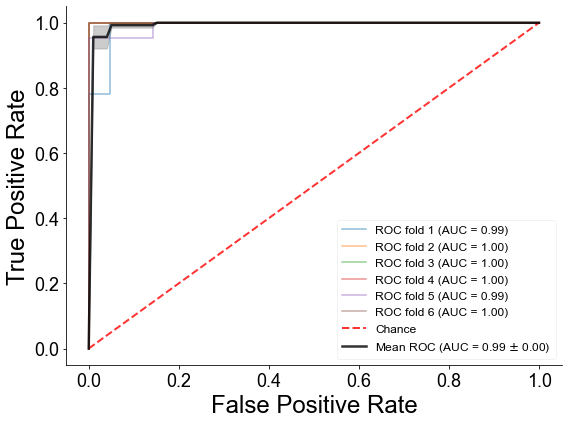

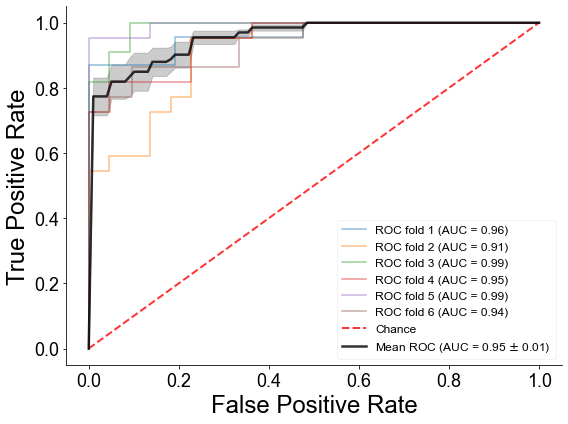

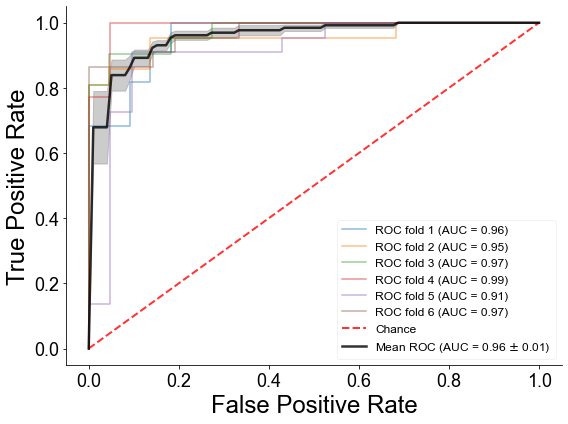

In [9]:
hf.plotROC(X, dx_ctrl_ad, rfe_protein_ctrl_ad, "cn_ad")
hf.plotROC(X, dx_ctrl_asym, rfe_protein_ctrl_asym, "cn_asym")
hf.plotROC(X, dx_asym_ad, rfe_protein_asym_ad, "asym_ad")

## Sigmoid plots which show the assigned probability

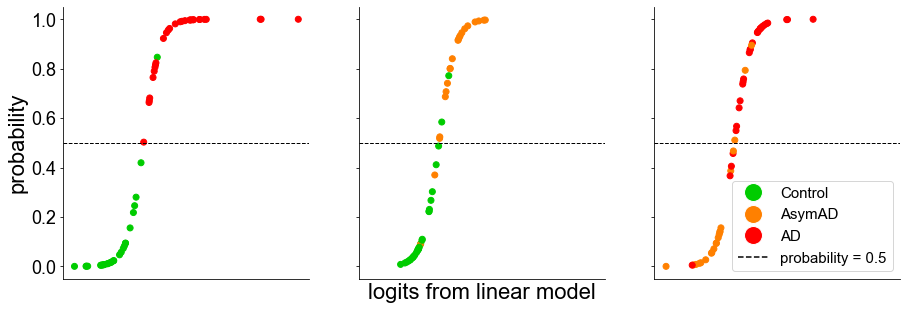

In [10]:
fs0=10; fs1 = 18; fs2 = 22; fs3 = 26; dpi = 300
hfont = {'fontname':'Arial'}
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
hf.logistic_plot(X, dx_tr_ctrl_ad, dx_te_ctrl_ad, rfe_protein_ctrl_ad, clf, ax[0], random_seed)
hf.logistic_plot(X, dx_tr_ctrl_asym, dx_te_ctrl_asym, rfe_protein_ctrl_asym, clf, ax[1], random_seed)
hf.logistic_plot(X, dx_tr_asym_ad, dx_te_asym_ad, rfe_protein_asym_ad, clf, ax[2], random_seed)
ax[0].set_ylabel("probability", fontsize=fs2, **hfont)
ax[1].set_xlabel("logits from linear model", fontsize=fs2, **hfont)
y_ticks = np.round(np.linspace(0,1,6),2)
ax[0].set_yticks(y_ticks)
ax[0].set_yticklabels(y_ticks, fontsize=fs1)

legend_elements = [Line2D([0], [0], marker='o', color="w", markerfacecolor="#00CC00", label='Control', markersize=fs1),
                   Line2D([0], [0], marker='o', color="w", markerfacecolor="#FF8000", label='AsymAD', markersize=fs1),
                  Line2D([0], [0], marker='o', color="w", markerfacecolor="#FF0000", label='AD', markersize=fs1),
                  Line2D([0], [0], color='k', linestyle="--", label='probability = 0.5')]

ax[2].legend(handles=legend_elements, loc='lower right', fontsize=fs0+5)
fig.savefig(os.path.join(figure_save_path, "sigmoid_plots.png"), dpi=600, transparent=True)

## TSNE-plots

KL-divergence 0.5974256992340088
KL-divergence 0.5165424346923828
KL-divergence 0.5215649604797363
KL-divergence 0.7493340969085693


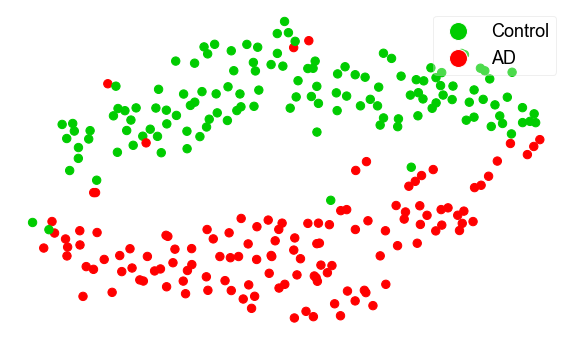

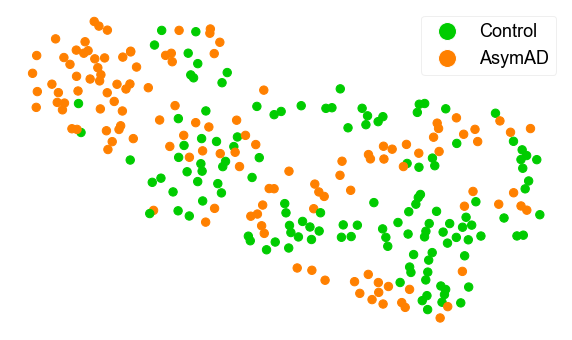

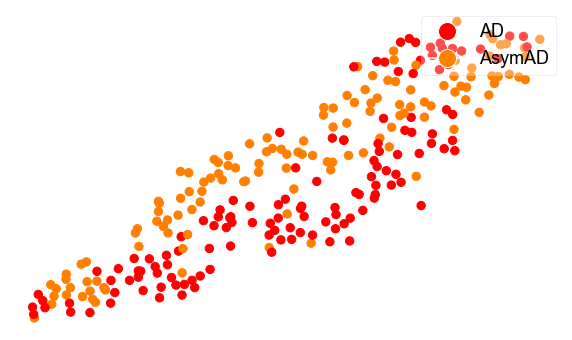

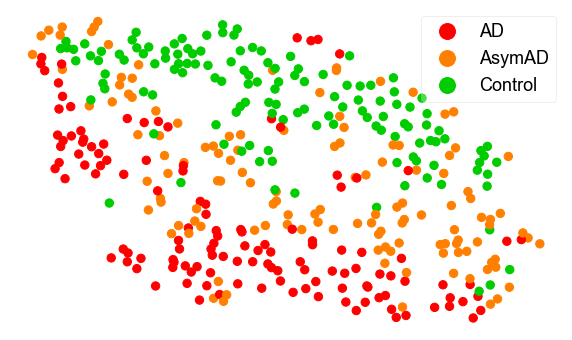

In [11]:
tsne_ctrl_ad =  hf.tsneProject(X, label_df, ["Control", "AD"], rfe_protein_ctrl_ad, "CNvsAD")
tsne_ctrl_asym = hf.tsneProject(X, label_df, ["Control", "AsymAD"], rfe_protein_ctrl_asym, "CNvsAsym")
tsne_asym_ad = hf.tsneProject(X, label_df, ["AD", "AsymAD"], rfe_protein_asym_ad, "ADvsAsym")
tsne_cn_asym_ad = hf.tsneProject(X, label_df, ["AD", "AsymAD", "Control"], rfe_protein_ctrl_ad, "ADvsAsymvsCN")

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



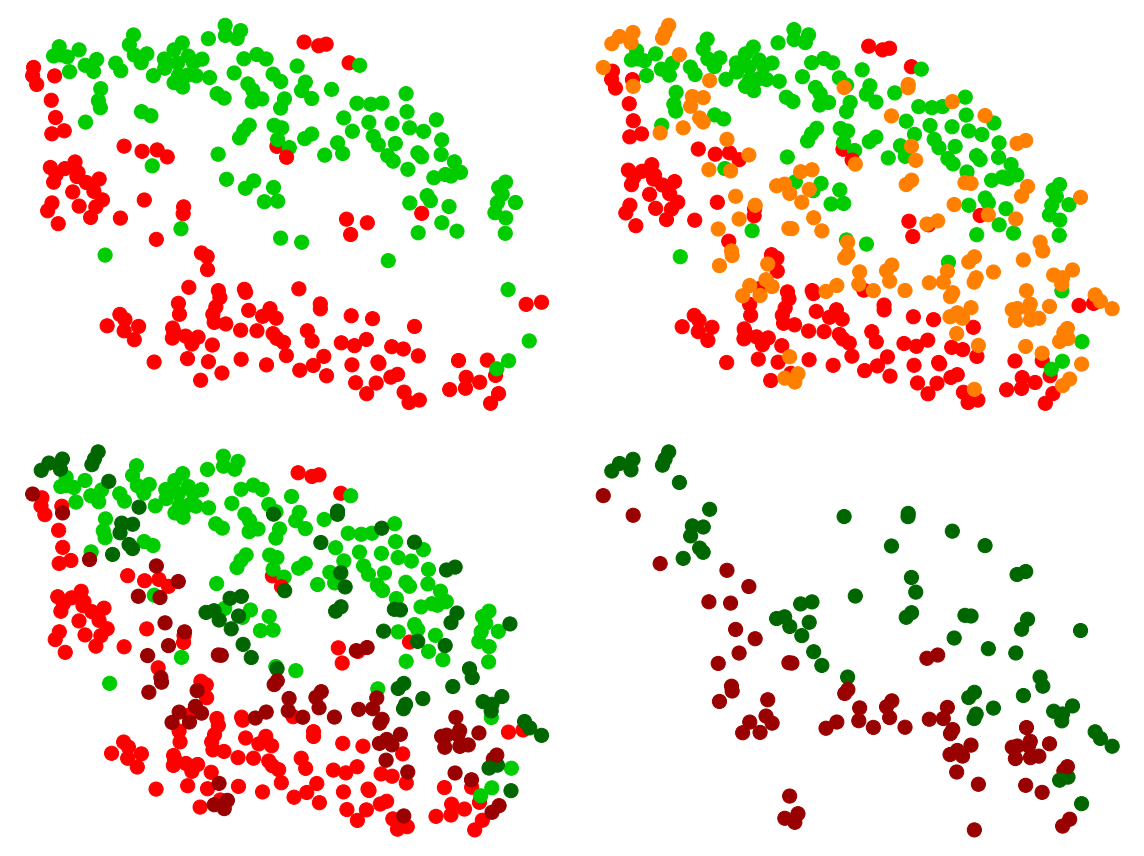

In [12]:
test_knn = hf.knnViz(tsne_cn_asym_ad, label_df, 5)
test_knn.set_index('sbj', inplace=True)
test_knn['sbj'] = test_knn.index

## Uncertainty Quantification

In [13]:
tsne_rs_exp = []
for r_ in range(5):
    tsne_r_ = hf.tsneProject(X, label_df, ["AD", "AsymAD", "Control"], rfe_protein_ctrl_ad, "ADvsAsymvsCN", r_)
    tsne_x = hf.knnViz(tsne_r_, label_df, 5).set_index('sbj')["predicted"]
    tsne_rs_exp.append(tsne_x.map({"Control":0, "AD":1}))
    print(r_)
    plt.close('all')

KL-divergence 0.7493340969085693


/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0
KL-divergence 0.7806787490844727


/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1
KL-divergence 0.7897117733955383


/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2
KL-divergence 0.7471675872802734


/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3
KL-divergence 0.7755833268165588


/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:439: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/raghavtandon/Documents/PhD/multi-modal/multi-modal-ad/helper_fn.py:440: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4


In [14]:
test_knn["prob-class"] = pd.concat(tsne_rs_exp, axis=1).mean(axis=1)
test_knn["entropy"] = entropy([test_knn["prob-class"], 1-test_knn["prob-class"]], base=2)
# pd.concat(tsne_rs_exp, axis=1).mean(axis=1)

In [15]:
master_path = "/Users/raghavtandon/Documents/PhD/multi-modal/data/masterDF_with_final_labels_imputed_genotype.csv"
master_df = pd.read_csv(master_path, index_col='sbj')
genotype_uncertainty = pd.merge(master_df["APOE_imputed_genotype"], test_knn[["entropy", "prob-class"]], left_index=True, right_index=True, how="inner")

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



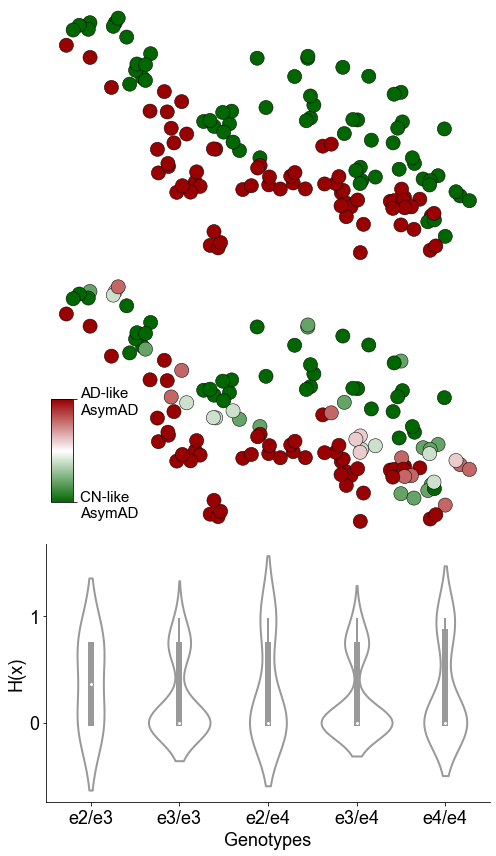

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(7,12), sharex=False)
lb2 = {'Control': "#006600", 'AD': "#990000"}
import matplotlib.colors
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), lb2["Control"]],
          [norm(0.5), 'white'],
          [norm( 1.0), lb2["AD"]]]
# colors = [[norm(0), 'k'],
#           [norm(0.5), 'lightgrey'],
#           [norm( 1.0), 'k']]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
order=["e2/e3", "e3/e3", "e2/e4", "e3/e4", "e4/e4"]
vln = sns.violinplot(data=genotype_uncertainty, x="APOE_imputed_genotype", 
               y="entropy", ax=ax[2], order=order, 
               color='w', linewidth=2,
              **{"edgecolor":'r'})
# sns.violinplot(data=genotype_uncertainty, x="APOE_imputed_genotype", y="entropy", ax=ax[1], order=order, color='white')
# ax.axis('off')
ax[2].spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_yticks([0, 1])
# ax[2].set_yticklabels(["CN-like \n AsymAD", "AD-like \n AsymAD"], fontname='Arial', fontsize=18)
ax[2].set_xticklabels(order, fontname='Arial', fontsize=18)
ax[2].set_xlabel('Genotypes', fontsize=18, fontname='Arial')
ax[2].set_yticklabels([0, 1], fontsize=18, fontname="Arial")
ax[2].set_ylabel('H(x)', fontname='Arial', fontsize=18)

ax[0].scatter(test_knn["tsne1"], test_knn["tsne2"],
                     c=test_knn["predicted"].replace(lb2), 
                      edgecolors='k', linewidths=0.5,
                     s=200)
ax[0].axis('off')
sc = ax[1].scatter(test_knn["tsne1"], test_knn["tsne2"], 
                c=test_knn["prob-class"],norm=norm, cmap=cmap, 
                edgecolors='k', linewidths=0.5, s=200)
ax[1].axis('off')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax[1], width="5%", height="40%", loc=3, 
                    bbox_to_anchor=(0,0.1,1,1), 
                    bbox_transform=ax[1].transAxes)
cbar = plt.colorbar(sc, cax=cbaxes, ticks=[0, 1], orientation='vertical')
cbar.ax.set_yticklabels(['CN-like \nAsymAD', 'AD-like \nAsymAD'], fontname='Arial', fontsize=15)
fig.tight_layout()
# fig.savefig(os.path.join(figure_save_path, "asym_label_uncertainty_supplement.png"), dpi=600, transparent=True)
# ax.collections[0].set_edgecolor('red')

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



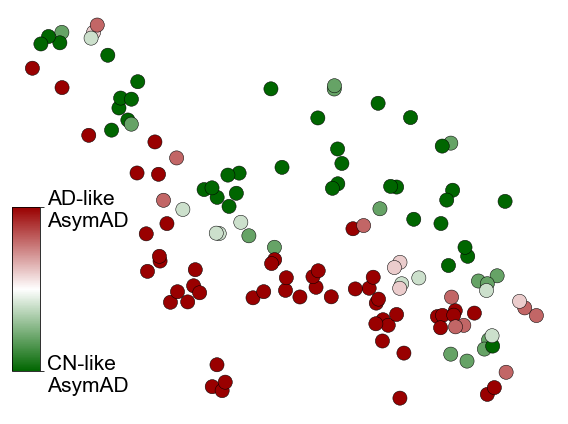

In [17]:
lb2 = {'Control': "#006600", 'AD': "#990000"}
import matplotlib.colors
norm = matplotlib.colors.Normalize(0,1)
colors = [[norm(0), lb2["Control"]],
          [norm(0.5), 'white'],
          [norm( 1.0), lb2["AD"]]]
# colors = [[norm(0), 'k'],
#           [norm(0.5), 'darkgrey'],
#           [norm( 1.0), 'w']]
# colors = [[norm(0), 'k'],
# #           [norm(0.25), 'lightgrey'],
#           [norm(0.5), 'white'],
# #           [norm(0.75), 'lightgrey'],
#           [norm( 1.0), 'k']]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# pd.concat(tsne_rs_exp, axis=1).mean(axis=1), test_knn
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc = ax.scatter(test_knn["tsne1"], test_knn["tsne2"], 
                c=test_knn["prob-class"],norm=norm, cmap=cmap, 
                edgecolors='k', linewidths=0.5, s=200)
ax.axis('off')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="5%", height="40%", loc=3, 
                    bbox_to_anchor=(0,0.1,1,1), 
                    bbox_transform=ax.transAxes) 
cbar = plt.colorbar(sc, cax=cbaxes, ticks=[0, 1], orientation='vertical')
cbar.ax.set_yticklabels(['CN-like \nAsymAD', 'AD-like \nAsymAD'], fontname='Arial', fontsize=21)

# plt.colorbar(sc)
fig.tight_layout()
# fig.savefig(os.path.join(figure_save_path, "asym_label_uncertainty.png"), dpi=600, transparent=True)

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



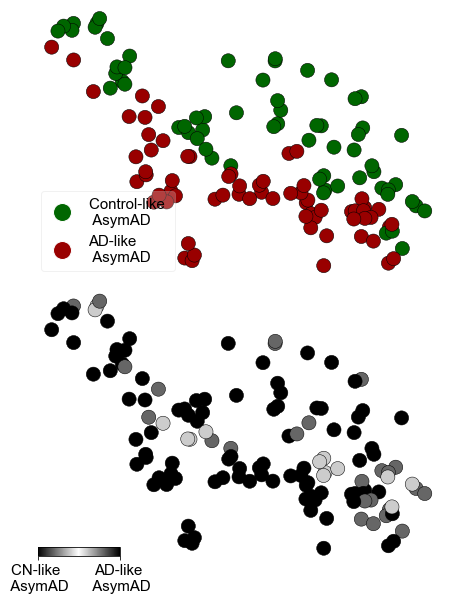

In [18]:
lb2 = {'Control': "#006600", 'AD': "#990000"}
import matplotlib.colors
norm = matplotlib.colors.Normalize(0,1)
# colors = [[norm(0), 'white'],
#           [norm(0.5), 'lightgrey'],
#           [norm( 1.0), 'k']]
colors = [[norm(0), 'k'],
          [norm(0.5), 'w'],
          [norm( 1.0), 'k']]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig, ax = plt.subplots(2, 1, figsize=(6,8), sharex=False)
classes10 = ["Control", "AD"]
classes11 = ["Control-like \n AsymAD", "AD-like \n AsymAD"]
legend_properties = {'size':15, 'family':'Arial'}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
ax[0].legend(recs11, [i for i in classes11], fontsize=15,
                 prop=legend_properties,
				framealpha=0.25,
				loc=3)
order=["e2/e3", "e3/e3", "e2/e4", "e3/e4", "e4/e4"]
ax[0].scatter(test_knn["tsne1"], test_knn["tsne2"],
                     c=test_knn["predicted"].replace(lb2),
                     s=200, edgecolors='k', linewidths=0.5)
ax[0].axis('off')
sc = ax[1].scatter(test_knn["tsne1"], test_knn["tsne2"], 
                c=test_knn["prob-class"],norm=norm, cmap=cmap, 
                edgecolors='k', linewidths=0.5, s=200)


ax[1].axis('off')
cbaxes = inset_axes(ax[1], width="20%", height="3%", loc=3) 
cbar = plt.colorbar(sc, cax=cbaxes, ticks=[0, 1], orientation='horizontal')
cbar.ax.set_xticklabels(['CN-like \n AsymAD', 'AD-like \n AsymAD'], fontname='Arial', fontsize=15)
fig.tight_layout()
# fig.savefig(os.path.join(figure_save_path, "Asym_stratification_uncertainty.png"), 
#             dpi=600, transparent=False)
# sns.violinplot(data=genotype_uncertainty, x="APOE_imputed_genotype", y="entropy", ax=ax[1], order=order, color='white')
# ax.axis('off')




# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# ax.collections[0].set_edgecolor('red')

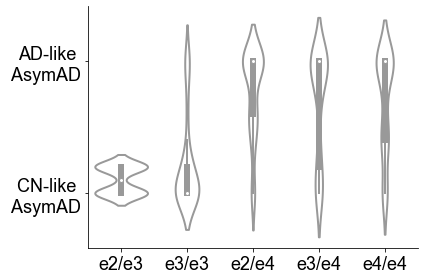

In [19]:
fig, ax = plt.subplots(figsize=(6,4), sharex=False)
vln = sns.violinplot(data=genotype_uncertainty, x="APOE_imputed_genotype", 
               y="prob-class", ax=ax, order=order, 
               color='w', linewidth=2, bw=0.4)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 1])
ax.set_yticklabels(["CN-like \n AsymAD", "AD-like \n AsymAD"], fontname='Arial', fontsize=18)
ax.set_xticklabels(order, fontname='Arial', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('')
fig.tight_layout()
fig.savefig(os.path.join(figure_save_path, "asym_prob_class_genotype.png"), dpi=600, transparent=False)

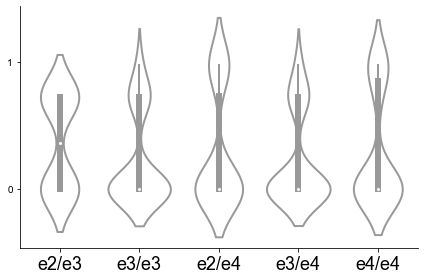

In [20]:
fig, ax = plt.subplots(figsize=(6,4), sharex=False)
vln = sns.violinplot(data=genotype_uncertainty, x="APOE_imputed_genotype", 
               y="entropy", ax=ax, order=order, 
               color='w', linewidth=2, bw=0.4)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 1])
# ax.set_yticklabels(["CN-like \n AsymAD", "AD-like \n AsymAD"], fontname='Arial', fontsize=18)
ax.set_xticklabels(order, fontname='Arial', fontsize=18)
ax.set_xlabel('')
ax.set_ylabel('')
fig.tight_layout()
fig.savefig(os.path.join(figure_save_path, "asym_entropy_genotype.png"), dpi=600, transparent=False)

In [ ]:
from permutation_test import runPipeline, randomTest
cn_ad_list = [("Control", 0), ("AD", 1)]
k=100
runPipeline(randomTest, X_unscaled, "RFE", X.columns, dx_tr_ctrl_ad, dx_te_ctrl_ad, cn_ad_list, 100000, "cn_ad", k, 14)

### AsymAD analysis

In [21]:
del test_knn['sbj']
test_knn.reset_index(inplace=True)

In [22]:
asym_predictions = test_knn[["sbj", "predicted"]]
asym_train = labels_train[labels_train["DX"].isin(["AsymAD"])]
asym_test = labels_test[labels_test["DX"].isin(["AsymAD"])]
asym_train = pd.merge(asym_predictions, asym_train, on="sbj", how="inner")
asym_test = pd.merge(asym_predictions, asym_test, on="sbj", how="inner")

In [23]:
del asym_train["DX"], asym_test["DX"]
asym_train.rename(columns={"predicted":"DX"}, inplace=True)
asym_test.rename(columns={"predicted":"DX"}, inplace=True)
asym_predictions.rename(columns={"predicted":"DX"}, inplace=True)
### IMPORTANT - FINAL RESULTS USE JMI FOR intra-asym selection
method="JMI"
# mifs_protein_asym_knn = hf.protein_selection(X, asym_train, 14, random_seed)
mifs_protein_asym_knn = hf.mifs_selection(X, asym_train, method, 5, random_seed)
# mifs_protein_asym_knn = summary_volcano[summary_volcano['-log10(p-val)'] > -np.log10(0.001)].sort_values('-log10(p-val)').index.tolist()[-7:]
y_test_asym, y_pred_asym = hf.prediction_fn(X, asym_train, asym_test, mifs_protein_asym_knn,
										clf, random_seed)
print(mifs_protein_asym_knn)

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['LGADMEDVR', 'GLQEAAEER', 'LGADMEDVCGR', 'YDNSLK', 'AQALEQAK']


In [24]:
print("Control-like vs AD-like AsymAD", sm.accuracy_score(y_test_asym, y_pred_asym), len(mifs_protein_asym_knn))

Control-like vs AD-like AsymAD 0.8095238095238095 5


0.8016528925619835
0.859504132231405
0.9173553719008264
0.8347107438016529
0.8272727272727274
0.7454545454545454
AuC 0.83099173553719


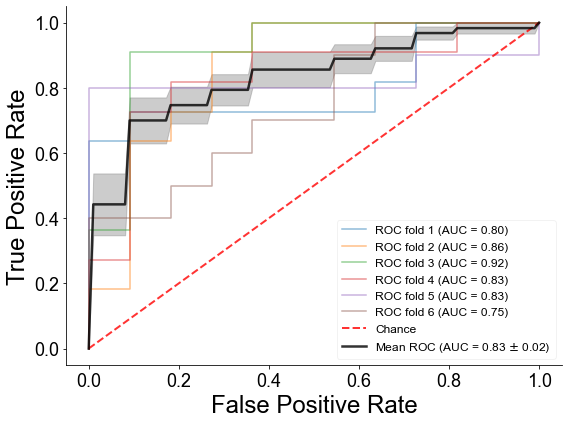

In [25]:
hf.plotROC(X, asym_predictions, mifs_protein_asym_knn, "intra_asym")

In [46]:
gt_dummies = pd.get_dummies(master_df["APOE_imputed_genotype"])
X_gt = pd.merge(X, gt_dummies, left_index=True, right_index=True)
X_gt["both_gt"] = X_gt["e2/e4"] + X_gt["e3/e4"]
X_gt["no_e4"] = X_gt["e2/e2"] + X_gt["e2/e3"] + X_gt["e3/e3"]

0.6859504132231405
0.6983471074380164
0.7768595041322314
0.6487603305785123
0.5727272727272728
0.6499999999999999
AuC 0.672107438016529


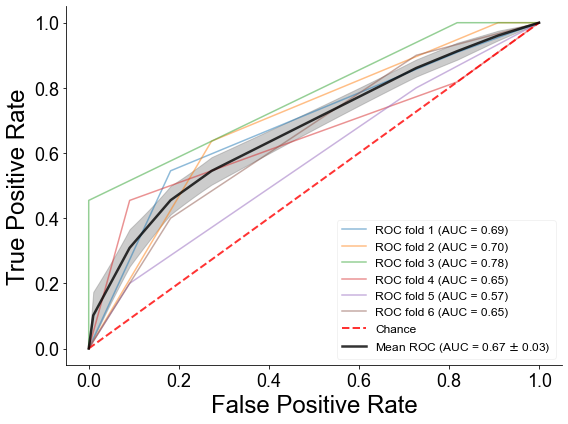

In [51]:
# genotype_peps = ["e2/e2", "e2/e3", "e2/e4", "e3/e3", "e3/e4", "e4/e4"]
# genotype_peps = ["AQALEQAK", "GLQEAAEER", "YDNSLK", "e4/e4", "both_gt", "no_e4"]
genotype_peps = ["e4/e4", "both_gt", "no_e4"]
hf.plotROC(X_gt, asym_predictions, genotype_peps, "genotype_intra_asym")

In [52]:
y_test_asym, y_pred_asym = hf.prediction_fn(X_gt, asym_train, asym_test, genotype_peps,
										clf, random_seed)

In [53]:
print("Control-like vs AD-like AsymAD", sm.accuracy_score(y_test_asym, y_pred_asym), len(mifs_protein_asym_knn))

Control-like vs AD-like AsymAD 0.5714285714285714 5


### Show all available fonts

In [ ]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## Volcano Plot - AsymAD

In [ ]:
x_volcano = X_unscaled[X_unscaled.index.isin(asym_predictions['sbj'])]
x_volcano = pd.merge(x_volcano, asym_predictions, left_index=True, right_on='sbj')
x_volcano.set_index('sbj', inplace=True)
volcano_means = x_volcano.groupby('DX').mean()
fc =np.log2(volcano_means.loc["AD", :]/volcano_means.loc["Control", :])
cn_volcano = x_volcano[x_volcano["DX"]=="Control"][X_unscaled.columns.tolist()]
ad_volcano = x_volcano[x_volcano["DX"]=="AD"][X_unscaled.columns.tolist()]
pvals_dict = {}
for pep in X_unscaled.columns.tolist():
    x_pep = cn_volcano[pep]
    y_pep = ad_volcano[pep]
    _, p = mannwhitneyu(x_pep, y_pep)
    pvals_dict[pep] = -np.log10(p)
# y_volcano = asym_predictions['DX']
# x_volcano = x_volcano.reindex(asym_predictions['sbj'])

In [ ]:
summary_volcano = pd.concat([fc, pd.Series(pvals_dict)], axis=1)
summary_volcano.columns = ['log2(FC)', '-log10(p-val)']

In [ ]:
summary_volcano

In [ ]:
# fig = px.scatter(summary_volcano, x="log2(FC)", y='-log10(p-val)',
#                  text=summary_volcano.index, si)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(summary_volcano['log2(FC)'], summary_volcano['-log10(p-val)'], alpha=0.25)
ax.axvline(0, 0, 1, linestyle='--', color='k', label="FC = 0")
# ax.axhline(3, -0, 1, linestyle='--', label='p-val <= 0.001', color='r')
ax.axhline(-np.log10(0.05), -0, 1, linestyle='--', label=r'p-val = 0.05', color='r')
ax.set_xlabel(r'$\log_{2}$(FC)', fontsize=24, fontname="Arial")
ax.set_ylabel(r'-$\log_{10}$(p-val)', fontsize=24, fontname="Arial")
plt.legend(fontsize=18, loc=2, framealpha=0.25)
# top10 = summary_volcano[summary_volcano['-log10(p-val)'] > -np.log10(0.001)].sort_values('-log10(p-val)').index.tolist()
top10 = mifs_protein_asym_knn
for i_, _ in enumerate(top10):
    ax.annotate(_, (summary_volcano['log2(FC)'][_]-np.random.normal(0.4,0.1), 
                summary_volcano['-log10(p-val)'][_] -np.random.normal(0,0.2)),
                fontsize=21, fontname="Arial")
    ax.scatter(summary_volcano['log2(FC)'][_], 
           summary_volcano['-log10(p-val)'][_], 
           c='b', s=100, edgecolors='k',
          linewidths=2)
plt.xticks(fontsize=18, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([-1, 1.1])
fig.tight_layout()
fig.savefig(os.path.join(figure_save_path, "volcano_asym2.png"), dpi=600, transparent=True)
# fig = px.scatter(df, x="gdpPercap", y="lifeExp", text="country", log_x=True, size_max=100, color="lifeExp")
# fig.update_traces(textposition='top center')
# fig.show()

In [ ]:
# summary_volcano.sort_values('-log10(p-val)').index[-10:]
# summary_volcano[summary_volcano['-log10(p-val)'] > -np.log10(0.001)].sort_values('-log10(p-val)').index.tolist()

## Volcano plots - CN/AD

In [ ]:
cn_ad_df = label_df[label_df['DX'].isin(['Control', 'AD'])]
x_volcano = X_unscaled[X_unscaled.index.isin(cn_ad_df['sbj'])]
x_volcano = pd.merge(x_volcano, cn_ad_df, left_index=True, right_on='sbj')
x_volcano.set_index('sbj', inplace=True)
volcano_means = x_volcano.groupby('DX').mean()
fc =np.log2(volcano_means.loc["AD", :]/volcano_means.loc["Control", :])
cn_volcano = x_volcano[x_volcano["DX"]=="Control"][X_unscaled.columns.tolist()]
ad_volcano = x_volcano[x_volcano["DX"]=="AD"][X_unscaled.columns.tolist()]
pvals_dict = {}
for pep in X_unscaled.columns.tolist():
    x_pep = cn_volcano[pep]
    y_pep = ad_volcano[pep]
    _, p = mannwhitneyu(x_pep, y_pep)
    pvals_dict[pep] = -np.log10(p)
# y_volcano = asym_predictions['DX']
# x_volcano = x_volcano.reindex(asym_predictions['sbj'])

In [ ]:
summary_volcano = pd.concat([fc, pd.Series(pvals_dict)], axis=1)
summary_volcano.columns = ['log2(FC)', '-log10(p-val)']

In [ ]:
# fig = px.scatter(summary_volcano, x="log2(FC)", y='-log10(p-val)',
#                  text=summary_volcano.index, si)

fig, ax = plt.subplots(figsize=(6,5.06))
ax.scatter(summary_volcano['log2(FC)'], summary_volcano['-log10(p-val)'], alpha=0.25)
ax.axvline(0, 0, 1, linestyle='--', color='k', label='FC = 0')
# ax.axhline(3, -0, 1, linestyle='--', label='p-val <= 0.001', color='r')
ax.axhline(-np.log10(0.05), -0, 1, linestyle='--', label='p-val = 0.05', color='r')
ax.set_xlabel(r'$\log_{2}$FC', fontsize=21, fontname="Arial")
ax.set_ylabel(r'-$\log_{10}$p-val', fontsize=21, fontname="Arial")
# top10 = summary_volcano[summary_volcano['-log10(p-val)'] > -np.log10(0.001)].sort_values('-log10(p-val)').index.tolist()
top10 = rfe_protein_ctrl_ad
for i_, _ in enumerate(top10):
    ax.annotate(_, (summary_volcano['log2(FC)'][_]-np.random.normal(0,0.5), summary_volcano['-log10(p-val)'][_] + np.random.normal(-0.5,0.5)), 
                fontsize=18, fontname="Arial")
    ax.scatter(summary_volcano['log2(FC)'][_], 
               summary_volcano['-log10(p-val)'][_], 
               c='b', s=100, edgecolors='k',
              linewidths=2)
ax.set_xlim([-4, 4])
ax.legend(fontsize=18, loc=2, framealpha=0.25)
# fig.tight_layout()
plt.xticks(fontsize=18, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig(os.path.join(figure_save_path, "volcano_cnad.png"), dpi=600, transparent=True,bbox_inches='tight')
# fig = px.scatter(df, x="gdpPercap", y="lifeExp", text="country", log_x=True, size_max=100, color="lifeExp")
# fig.update_traces(textposition='top center')
# fig.show()

## MoCA correlation plots

In [ ]:
path = "/Users/raghavtandon/Documents/PhD/multi-modal/data/masterDF_with_final_labels.csv"
df = pd.read_csv(path)
fmt='png'
neuro_eval = "MoCA"
df.dropna(axis=0, subset=[neuro_eval], inplace=True)
# Split the df sub-categories
df_dict = {}
labels = ["Control", "Control-like AsymAD", "AD-like AsymAD", "AD"]
for i in labels:
	df_dict[i] = df[df["predicted_final"] == i]
df_dict["AsymAD"] = df[df["DX"] == "AsymAD"]
df_dict["overall"] = df

# Identify the peptides
peptides = df.iloc[:,62:137].columns.tolist()
# Different fields for which correlation is calculated
cols = ["overall", "Control", "AsymAD", "Control-like AsymAD", "AD-like AsymAD", "AD"]
corr_df = pd.DataFrame(index=peptides, columns=cols)
for i in peptides:
	for k, v in df_dict.items():
		tau, p = stats.kendalltau(v[neuro_eval], v[i])
		corr_df.at[i, k] = tau

corr_df = corr_df.astype(float)
corr_df.sort_values("overall", inplace=True, ascending=False)
final_labels = ["overall"]#+["Control", "AsymAD", "Control-like AsymAD", "AD-like AsymAD"]
#corr_df = corr_df[["overall", "Control", "AsymAD", "AD"]]
corr_df = corr_df[final_labels]
fig, ax = plt.subplots(1,1, figsize=(6, 21))
sns.heatmap(corr_df, vmin=None, vmax=None, center=0.0, cbar=True, cmap="bwr", ax=ax, 
	xticklabels=False, yticklabels=True, cbar_kws={"shrink": .25}, annot=False, 
            fmt=".2f", annot_kws={"fontsize":10}, square=True)
# ax.set_xticklabels(corr_df.columns.tolist(), rotation=60, fontsize=21, ha="right")
ax.set_yticklabels(corr_df.index.tolist(), rotation=0, fontsize=21, ha="right")
for t in plt.gca().get_yticklabels():
	if t.get_text() in rfe_protein_ctrl_ad:
		t.set_color("k")
		t.set_fontfamily("sans-serif")
		t.set_fontweight("heavy")
	else:
		t.set_fontfamily("sans-serif")
		t.set_fontweight("ultralight")
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=21)
fig.tight_layout()
fig.savefig(os.path.join(figure_save_path, "neuro_heatmap_{}_cn_ad_sorted_overall.{}".format(neuro_eval, fmt)), 
            format=fmt, dpi=600, transparent=True)
plt.close("all")

## Confusion Matrix

In [ ]:
def norm_cnf(cnf):
    return cnf/cnf.sum(axis=1)[:,None]

def get_cnf_mat(clf, X, y, cv=6):
    kcv = StratifiedKFold(n_splits=cv, random_state=0, shuffle=True)
    y_predict = model_selection.cross_val_predict(clf, X, y, cv=kcv)
    cnf_matrix = sm.confusion_matrix(y, y_predict)
    return cnf_matrix

In [ ]:
random_seed

In [ ]:
# y_test_ca, y_pred_ca = hf.prediction_fn(X, dx_tr_ctrl_ad, dx_te_ctrl_ad, rfe_protein_ctrl_ad,
# 										clf, random_seed)
y_test_ca, y_pred_ca = hf.prediction_fn(X, asym_train, asym_test, mifs_protein_asym_knn,
										clf, random_seed)

In [ ]:
pep_cnf = sm.confusion_matrix(y_test_ca, y_pred_ca)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
fmt = 'png'
labels = ["AD-like \n AsymAD","CN-like \n AsymAD"]
# labels = ["AD", "CN"]
sns.heatmap(norm_cnf(pep_cnf), annot=pep_cnf, cmap="Greys", fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"fontsize":18})
ax.set_xticklabels(labels, fontsize=18, fontname="Arial")
ax.set_yticklabels(labels, fontsize=18, fontname="Arial")
# ax.xaxis.tick_top()
ax.set_xlabel("Predicted", fontsize=21, fontweight="heavy", fontname="Arial")
ax.set_ylabel("Labeled", fontsize=21, fontweight="heavy", fontname="Arial")
fig.tight_layout()
fig.savefig(os.path.join(figure_save_path, "intra_asym_heatmap.{}".format(fmt)), 
            format=fmt, dpi=600, transparent=True)
# ax.tick_params(labelbottom=False,labeltop=True)
# ax.label_params
# ax.xaxis.set_tick_params(labeltop=True)
# ax.xaxis.set_tick_params(labelbottom=False)

In [ ]:
Counter(y_test_ca)

In [ ]:
fig, ax = plt.subplots()
hf.logistic_plot(X, asym_train, asym_test, mifs_protein_asym_knn, clf, ax)

In [ ]:
mifs_protein_asym_knn

In [ ]:
new_assignments =pd.merge(master_df["APOE_imputed_genotype"],
                    test_knn[["sbj", "predicted"]], 
                    left_index=True, 
                    right_on='sbj', how="inner")

In [ ]:
new_assignments.pivot_table(values='APOE_imputed_genotype', index='predicted', aggfunc=np.count_nonzero)

In [ ]:
new_assignments.pivot_table(index='APOE_imputed_genotype', columns='predicted', values='sbj', aggfunc=np.count_nonzero)

In [ ]:
17/21